In [18]:
import scanpy as sc
import csv
import yaml
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse

# Load the processed data -- Load only the dataset you want to plot
adata = sc.read_h5ad("/Users/aumchampaneri/Databases/Mm_MKA-pp.h5ad")  # Full dataset

# Load the gene dictionary from the csv file
gene_dict = {}
with open('complement_gene_dictionary.csv', newline='') as file:
    reader = csv.reader(file)
    next(reader)  # Skip header
    for row in reader:
        gene_dict[row[0]] = row[1]

# Load the tissue type dictionary from the yaml file
with open("Tissue Type Dictionary.yaml", "r") as file:
    cell_type_group = yaml.safe_load(file)

# Map cell types to groups
adata.obs['cell_type_group'] = 'Other'
for group, cell_types in cell_type_group.items():
    adata.obs.loc[adata.obs['cell_type'].isin(cell_types), 'cell_type_group'] = group

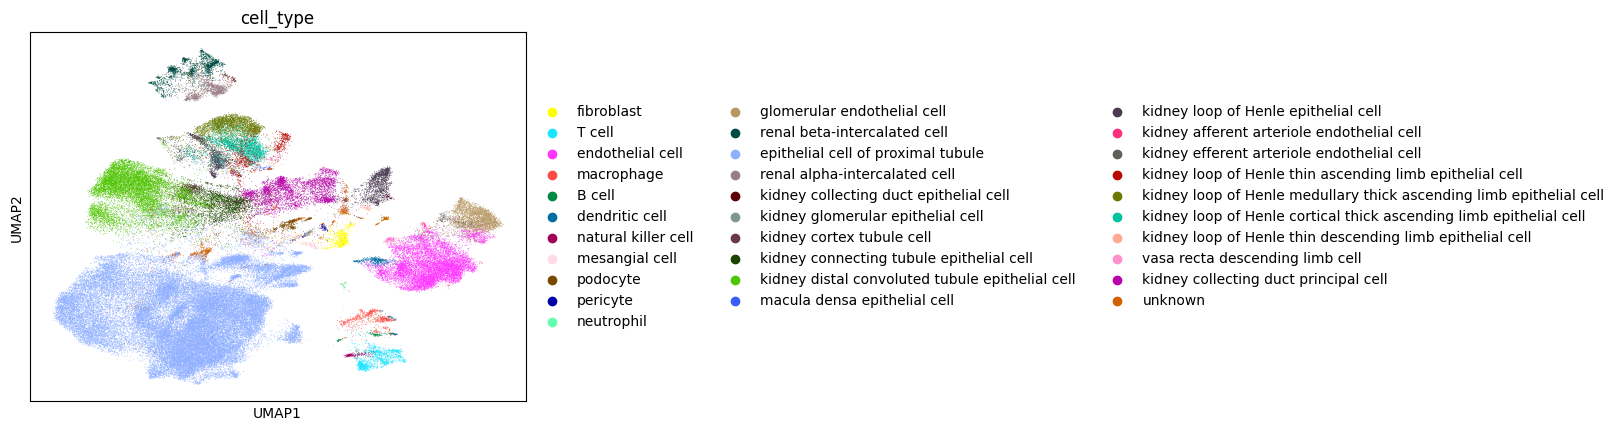

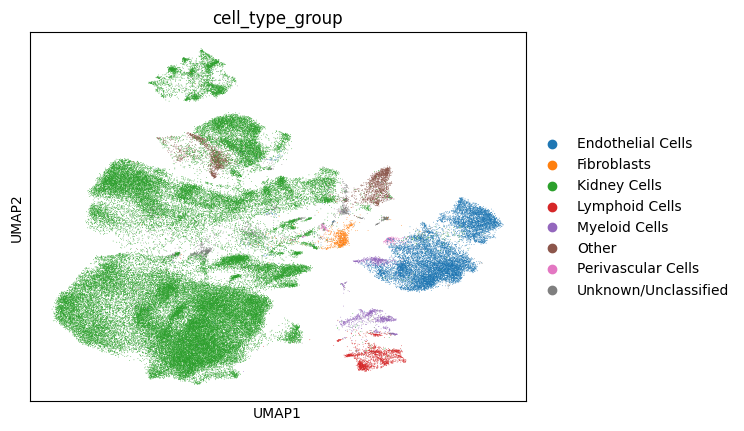

In [3]:
'''
UMAP Plotting
This code will plot UMAP for the processed data and color the points by cell type and tissue type.
'''

# Plot UMAP colored by cell type
sc.pl.umap(adata,
           color='cell_type',
           # save='_cell-type.pdf'
           )

# Plot the UMAP colored by tissue type
sc.pl.umap(adata,
           color=['cell_type_group'],
           # save='_cell-type-group.pdf'
           )

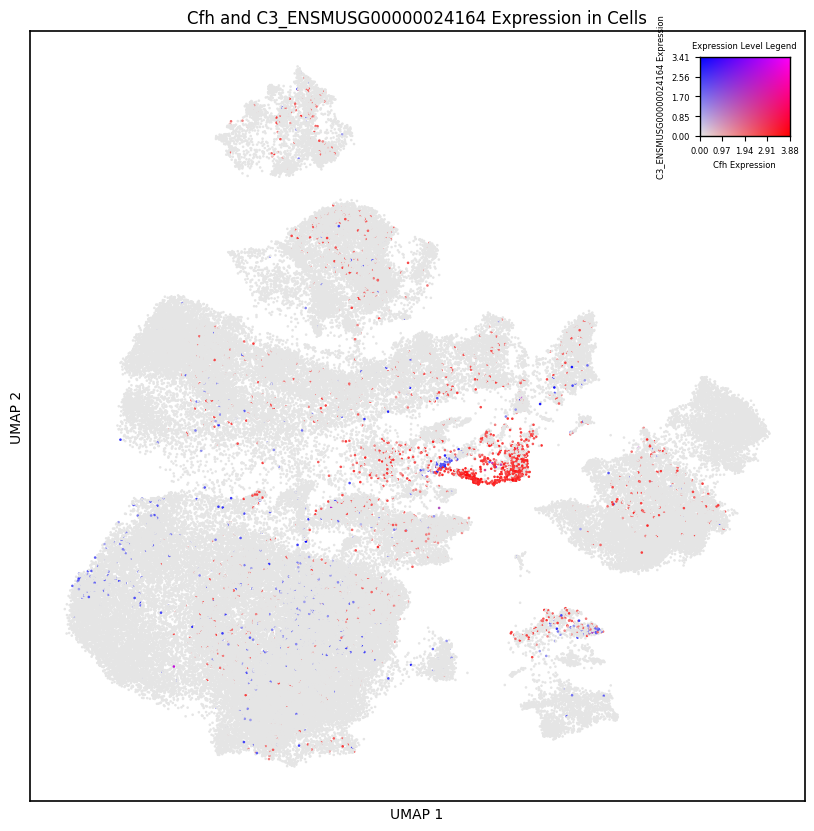

In [17]:

'''
UMAP Plot – Comparing Gene Expression
This code will plot UMAP for the processed data and color the points by gene expression.

The function `plot_gene_expression` takes two gene keys and a dictionary mapping Ensembl gene IDs to gene names.
It generates a UMAP plot with a custom colormap based on the expression levels of the two genes.
The function also creates a legend showing the expression levels of both genes.
The UMAP plot is saved to a specified path if provided.
'''


# noinspection PyTypeChecker
def umap_gene_expression(adata, disease, gene1, gene2, gene_dict, save_path=None):
    """
    Creates a UMAP visualization of two genes' expression patterns across cells with a custom colormap.

    This function plots cells on a UMAP projection and colors each cell based on the relative expression
    of two genes, using a bivariate color scheme:
    - Red: High expression of gene1, low expression of gene2
    - Blue: Low expression of gene1, high expression of gene2
    - Purple: High expression of both genes
    - White/light gray: Low expression of both genes

    Parameters
    ----------
    adata : AnnData
        AnnData object containing single-cell RNA-seq data with UMAP coordinates in adata.obsm['X_umap'].
    disease : str
        The disease state to subset (e.g., 'AKI', 'CKD', 'Reference').
    gene1 : str
        Name of the first gene to visualize (will be mapped to red).
    gene2 : str
        Name of the second gene to visualize (will be mapped to blue).
    gene_dict : dict
        Dictionary mapping gene names to Ensembl IDs for lookup in the expression matrix.
    save_path : str, optional
        Path to save the figure. If None, the figure is displayed but not saved.

    Returns
    -------
    None
        The function displays or saves the plot but doesn't return any values.

    Notes
    -----
    - Expression values are min-max normalized for each gene before visualization
    - A small legend is added showing the bivariate color scale
    - The function handles both sparse and dense expression matrices
    """

    # Subset data based on disease type
    adata = adata[adata.obs['disease_ontology_term_id'] == disease, :].copy()

    # Fetch Ensembl ID from dictionary or return original gene name
    def get_ensembl_id(gene_name):
        return gene_dict.get(gene_name, gene_name)

    # Extract and flatten gene expression values
    def get_expression(ensembl_id):
        exp = adata[:, ensembl_id].X
        return exp.toarray().ravel() if scipy.sparse.issparse(exp) else exp.ravel()

    # Compute RGB color mapping from normalized expressions
    def compute_colors(x_scatter, y_scatter, white_val=0.9):
        w = (1 - x_scatter) * (1 - y_scatter)
        r = x_scatter * (1 - y_scatter)
        b = (1 - x_scatter) * y_scatter
        p = x_scatter * y_scatter
        return np.clip(np.column_stack([
            white_val * w + r + p,  # Red
            white_val * w,  # Green
            white_val * w + b + p  # Blue
        ]), 0, 1)

    # Get Ensembl IDs and expressions for both genes
    gene1_ensembl = get_ensembl_id(gene1)
    gene2_ensembl = get_ensembl_id(gene2)
    g1_vals = get_expression(gene1_ensembl)
    g2_vals = get_expression(gene2_ensembl)

    # Normalize the gene expressions
    g1_min, g1_max = g1_vals.min(), g1_vals.max()
    g2_min, g2_max = g2_vals.min(), g2_vals.max()
    g1_scaled = (g1_vals - g1_min) / (g1_max - g1_min)
    g2_scaled = (g2_vals - g2_min) / (g2_max - g2_min)

    # Compute the scatter plot colors
    scatter_colors = compute_colors(g1_scaled, g2_scaled)

    # Plot setup
    fig, ax_umap = plt.subplots(figsize=(10, 10), facecolor='white')
    ax_umap.set_facecolor('white')

    # Scatter plot of UMAP results
    ax_umap.scatter(
        adata.obsm['X_umap'][:, 0], adata.obsm['X_umap'][:, 1],
        c=scatter_colors, s=0.75, alpha=1.0
    )

    # Set title and axis labels
    ax_umap.set_title(f'{gene1} and {gene2} Expression in Cells')
    ax_umap.set_xlabel('UMAP 1')
    ax_umap.set_ylabel('UMAP 2')
    ax_umap.grid(False)
    ax_umap.set_xticks([])
    ax_umap.set_yticks([])

    # Customize axes and figure spines
    for spine in ax_umap.spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1.2)

    # Add legend for the color scale
    legend_width, legend_height = 0.09, 0.09
    ax_legend = fig.add_axes([0.885 - legend_width, 0.86 - legend_height, legend_width, legend_height])

    # Create a mesh grid for the legend's expression levels
    x_lin = np.linspace(g1_min, g1_max, 100)
    y_lin = np.linspace(g2_min, g2_max, 100)
    X_leg_scaled, Y_leg_scaled = np.meshgrid((x_lin - g1_min) / (g1_max - g1_min),
                                             (y_lin - g2_min) / (g2_max - g2_min))

    # Display the color scale
    ax_legend.imshow(compute_colors(X_leg_scaled.ravel(), Y_leg_scaled.ravel()).reshape(100, 100, 3),
                     origin='lower', extent=[g1_min, g1_max, g2_min, g2_max])

    # Set legend labels
    g1_ticks = np.linspace(g1_min, g1_max, num=5)
    g2_ticks = np.linspace(g2_min, g2_max, num=5)

    ax_legend.set_xticks(g1_ticks)
    ax_legend.set_yticks(g2_ticks)
    ax_legend.set_xticklabels([f"{val:.2f}" for val in g1_ticks], fontsize=6)
    ax_legend.set_yticklabels([f"{val:.2f}" for val in g2_ticks], fontsize=6)

    ax_legend.set_xlabel(f'{gene1} Expression', fontsize=6)
    ax_legend.set_ylabel(f'{gene2} Expression', fontsize=6)
    ax_legend.set_title('Expression Level Legend', fontsize=6)
    ax_legend.grid(False)

    for spine in ax_legend.spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)

    # Save or show plot
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    else:
        plt.show()


disease = 'PATO:0000461'  # Choose the disease you want to plot (AKI, CKD, Reference)

# Plot UMAP of C3 and CFH expression
umap_gene_expression(adata, f"{disease}", "Cfh", "C3", gene_dict)

# Plot UMAP of CFH and C3ar1 expression
# umap_gene_expression(adata, f"{disease}", "CFH", "C3AR1", gene_dict, save_path=f"{disease}_umap_CFHvC3ar1.pdf")
#
# # Plot UMAP of CFH and C5ar1 expression
# umap_gene_expression(adata, f"{disease}", "CFH", "C5AR1", gene_dict, save_path=f"{disease}_umap_CFHvC5ar1.pdf")
#
# # Plot UMAP of CFH and C5ar2 expression
# umap_gene_expression(adata, f"{disease}", "CFH", "C5AR2", gene_dict, save_path=f"{disease}_umap_CFHvC5ar2.pdf")
#
# # Plot UMAP of C3ar1 and C5ar1 expression
# umap_gene_expression(adata, f"{disease}", "C3AR1", "C5AR1", gene_dict, save_path=f"{disease}_umap_C3ar1vC5ar1.pdf")
#
# # Plot UMAP of C3ar1 and C5ar2 expression
# umap_gene_expression(adata, f"{disease}", "C3AR1", "C5AR2", gene_dict, save_path=f"{disease}_umap_C3ar1vC5ar2.pdf")
#
# # Plot UMAP of C5ar1 and C5ar2 expression
# umap_gene_expression(adata, f"{disease}", "C5AR1", "C5AR2", gene_dict, save_path=f"{disease}_umap_C5ar1vC5ar2.pdf")